# Digit Recognizer

This is a notebook to classify handwritten digits in the MNIST data set. Most of the code and implementation are borrowed from Chapters 1 and 2 of Michael Nielsen's [book](http://neuralnetworksanddeeplearning.com/) on neural networks and deep learning. The actual implementation code is hidden in the file, `network.py` in the `src` subdirectory. The MNIST data is downloaded from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

This problem is classified as a supervised classification problem. Supervised because we are inputting some subset of the MNIST data set to guide our model, and classification because we ultimately want to decide which digit the image is referring to in the range $0 - 9$ inclusive. 

In [1]:
import src.network as network

## import libraries
# standard libraries
import sys
import random
import gc

# third party libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn import svm


First we import the data that we previously downloaded:

In [2]:
training_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [ ]:
training_data.head()

In [ ]:
test_data.head()

In [ ]:
training_data.info() ; print('\n')
test_data.info()

So we see that our training set contains 42,000 images while our test set has 28,000 images.

Let's separate our training data into a training set and a validation set. The training set will be used to fit our model while we'll validate the model with the remaining data. For simplicity, we fit using the first 40,000 images in the training set and validate against the last 2,000 entries.

In [3]:
train_ar = np.array(training_data.iloc[:4000])
valid_ar = np.array(training_data.iloc[4000:4100])
test_ar  = np.array(test_data)

train_list = network.format_data (train_ar)
valid_list = network.format_data (valid_ar)

train_list = list(train_list)
valid_list = list(valid_list)

## SVM Baseline

Let's run a support vector machine baseline to see where we sit (this may take several minutes to execute)

In [21]:
baseline = svm.SVC()
    
# take slice 
input_svm = [image[1] for image in train_list]
output_svm = [image[0] for image in train_list] 
    
input_svm = list(map(np.ravel, input_svm))
 
print (input_svm)    

testing_in = [image[1] for image in valid_list]
testing_out = [image[0] for image in valid_list]
    
testing_in = list(map(np.ravel, testing_in))


baseline.fit(input_svm, output_svm)

predictions = [int(a) for a in baseline.predict(testing_in)]
    
correct = sum(int(a==y) for a, y in zip(predictions, testing_out))
    
print ("{} of {} values correct, {}%".format(correct, len(testing_out), correct/(len(testing_out))))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



91 of 100 values correct, 0.91%


Somewhere in the low 90% area. Not too shabby but let's see if we can do better with a neural network.

## Neural Network One

In [4]:
net = network.Network([784, 30, 10])
eval_list = []
(biases, weights) = net.SGD(train_list, 30, 10, 3.0, test_data = valid_list, store_eval = eval_list)

Epoch 0: 61 / 100
Epoch 1: 80 / 100
HIT
Epoch 2: 85 / 100
HIT
Epoch 3: 81 / 100
Epoch 4: 88 / 100
HIT
Epoch 5: 90 / 100
HIT
Epoch 6: 89 / 100
Epoch 7: 86 / 100
Epoch 8: 91 / 100
HIT
Epoch 9: 94 / 100
HIT
Epoch 10: 90 / 100
Epoch 11: 90 / 100
Epoch 12: 89 / 100
Epoch 13: 91 / 100
Epoch 14: 91 / 100
Epoch 15: 91 / 100
Epoch 16: 89 / 100
Epoch 17: 91 / 100
Epoch 18: 92 / 100
Epoch 19: 91 / 100
Epoch 20: 90 / 100
Epoch 21: 91 / 100
Epoch 22: 89 / 100
Epoch 23: 91 / 100
Epoch 24: 90 / 100
Epoch 25: 92 / 100
Epoch 26: 93 / 100
Epoch 27: 91 / 100
Epoch 28: 89 / 100
Epoch 29: 93 / 100


In [13]:
print (eval_list)

[0, 61, 80, 87, 87, 88, 90, 90, 90, 92, 93, 91, 93, 90, 91, 92, 92, 91, 91, 93, 90, 91, 92, 91, 91, 91, 91, 91, 92, 91, 92]


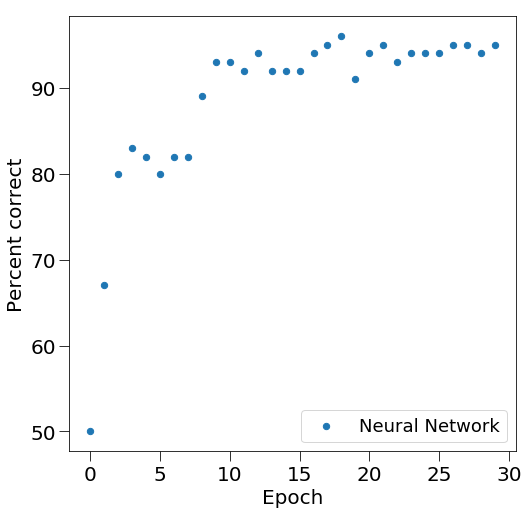

In [5]:
# import plotting/visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

# set custom plotting values
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20 
mpl.rcParams['ytick.labelsize'] = 20 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['lines.markersize'] = 1000
mpl.rcParams['legend.fontsize'] = 18


epoch_list = [a for a in range (0,len(eval_list)-1)]


# plot the function and data
plt.scatter(epoch_list, eval_list[1:], s=40, label="Neural Network")
plt.xlabel ("Epoch")
plt.ylabel ("Percent correct")
plt.legend()
plt.show()

In [5]:
def sigmoid(z):
    return (1.0/(1.0 + np.exp(-z)))

def feedforward(a, biases, weights):
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

In [6]:
max(eval_list)

94

In [7]:
predict_test = [(np.argmax(feedforward(image, biases, weights)), value) for value, image in valid_list]

In [44]:
for value, image in valid_list:
    print (image)

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     

In [12]:
print (predict_test)

[(8, 8), (8, 8), (0, 0), (5, 5), (0, 0), (0, 0), (3, 3), (8, 8), (2, 2), (1, 1), (2, 2), (5, 5), (6, 6), (3, 3), (0, 0), (6, 6), (6, 6), (1, 1), (3, 3), (9, 9), (6, 6), (0, 0), (2, 2), (4, 4), (6, 6), (3, 3), (2, 2), (7, 7), (8, 8), (5, 3), (2, 2), (9, 9), (9, 9), (4, 4), (9, 7), (2, 2), (7, 7), (5, 8), (6, 6), (1, 1), (3, 5), (0, 0), (9, 9), (3, 5), (5, 5), (2, 2), (5, 5), (7, 7), (4, 4), (0, 0), (2, 2), (9, 9), (8, 8), (3, 3), (2, 2), (1, 1), (2, 2), (4, 4), (6, 6), (2, 2), (3, 3), (3, 3), (2, 2), (1, 1), (0, 6), (8, 8), (5, 5), (5, 5), (6, 6), (1, 1), (8, 8), (4, 4), (4, 4), (4, 4), (7, 7), (8, 8), (1, 1), (2, 2), (0, 0), (4, 4), (5, 5), (8, 8), (2, 2), (3, 3), (7, 4), (2, 2), (9, 7), (7, 7), (9, 9), (4, 4), (7, 7), (5, 5), (1, 9), (5, 5), (5, 7), (0, 0), (4, 4), (0, 0), (6, 6), (8, 8)]


In [8]:
print(sum(int(x == y) for x, y in predict_test))

94
